## Regression Project

Build a linear regression model that predicts the `price` column in the dataset on San Francisco Apartment rentals. Make sure to go through all the the relevant steps of the modelling workflow.

1. Data Cleaning has already been performed on this data
2. Explore the data, keeping an eye on useful features and potential 
3. Choose a model validation scheme (simple or cross validation)
4. Fit a Linear Regression Model
5. Evaluate your model - check assumptions, metrics, and coefficient estimates
6. Engineer Features as needed
7. Repeat Steps 2, 4, 5, 6 as needed
8. Once you are ready, fit your final model and report final model performance estimate by scoring on the test data. Report both test R-squared and MAE.

A reasonable goal is to get a validation MAE of <= 500 dollars.

Advice:

1. "Perfect" is the enemy of "Good".
2. You will not get to an MAE of 0, we don't have perfect data, and there is some randomness and emotion in how things like apartment prices are set.
3. Modelling is challenging, especially if you're new. There isn't a "right" answer, but some models are better than others. Remember - "All Models are wrong, but some are useful" 
4. We will likely end up with different models and performance metrics, and that's ok. You can always implement new ideas after watching the solution video. I didn't do anything too fancy, so you might think of some great ideas I didn't!
5. Enjoy the process, and remember that at some point it's time to let the model go. No amount of feature engineering will achieve a perfect model.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score as r2, mean_absolute_error as mae, mean_squared_error as mse

rentals_df = pd.read_csv("Data/sf_clean.csv")

rentals_df.head()

,price,sqft,beds,bath,laundry,pets,housing_type,parking,hood_district
0,6800,1600.0,2.0,2.0,(a) in-unit,(d) no pets,(c) multi,(b) protected,7.0
1,3500,550.0,1.0,1.0,(a) in-unit,(a) both,(c) multi,(b) protected,7.0
2,5100,1300.0,2.0,1.0,(a) in-unit,(a) both,(c) multi,(d) no parking,7.0
3,9000,3500.0,3.0,2.5,(a) in-unit,(d) no pets,(c) multi,(b) protected,7.0
4,3100,561.0,1.0,1.0,(c) no laundry,(a) both,(c) multi,(d) no parking,7.0


### Data Dictionary

1. Price: The price of the rental and our target variable
2. sqft: The area in square feet of the rental
3. beds: The number of bedrooms in the rental
4. bath: The number of bathrooms in the rental
5. laundry: Does the rental have a laundry machine inside the house, a shared laundry machine, or no laundry on site?
6. pets: Does the rental allow pets? Cats only, dogs only or both cats and dogs?
7. Housing type: Is the rental in a multi-unit building, a building with two units, or a stand alone house? 
8. Parking: Does the apartment off a parking space? No, protected in a garage, off-street in a parking lot, or valet service?
9. Hood district: Which part of San Francisco is the apartment located?

![image info](SFAR_map.png)

In [2]:
rentals_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 989 entries, 0 to 988
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price          989 non-null    int64  
 1   sqft           989 non-null    float64
 2   beds           989 non-null    float64
 3   bath           989 non-null    float64
 4   laundry        989 non-null    object 
 5   pets           989 non-null    object 
 6   housing_type   989 non-null    object 
 7   parking        989 non-null    object 
 8   hood_district  989 non-null    float64
dtypes: float64(4), int64(1), object(4)
memory usage: 69.7+ KB


## EDA

1. Based on the range of prices below, we may need to subset our data based on some value to predict more "realistic" apartments. Possibly subset based on square-footage.

2. The 'hood_district' feature was read in as an integer but is really a categorical feature. Let's fix that.


In [3]:
rentals_df["hood_district"] = rentals_df["hood_district"].astype("object") 

In [4]:
rentals_df.describe()

,price,sqft,beds,bath
count,989.000000,989.000000,989.000000,989.000000
mean,3595.035389,976.765420,1.679474,1.390293
std,1546.222670,474.629798,1.076710,0.562714
min,750.000000,150.000000,0.000000,1.000000
25%,2650.000000,650.000000,1.000000,1.000000
50%,3300.000000,900.000000,2.000000,1.000000
75%,4242.000000,1200.000000,2.000000,2.000000
max,19000.000000,3500.000000,6.000000,4.000000


There are some very rare, expensive apartments that cost over 10k.

<Axes: xlabel='price', ylabel='Count'>

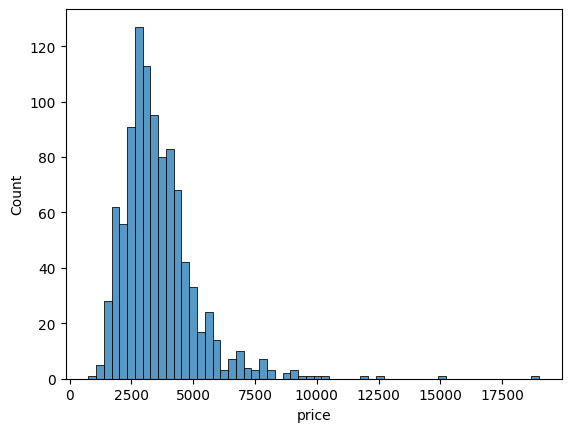

In [5]:
sns.histplot(rentals_df, x="price")

Most of our numeric features are positively correlated with each other, could cause problems.

It's good to see that we have some strong correlations with our target here though.

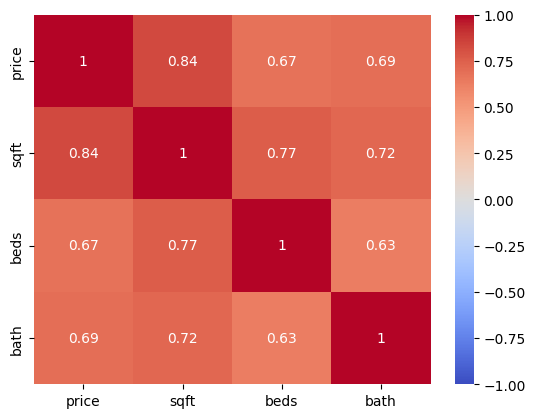

In [6]:
sns.heatmap(
    rentals_df.corr(numeric_only=True), 
    vmin=-1, 
    vmax=1, 
    cmap="coolwarm",
    annot=True
);

Based on the pairplot below, we may be able to slice off the most expensive aparments by subsetting to only aparments <2500 sqft. 

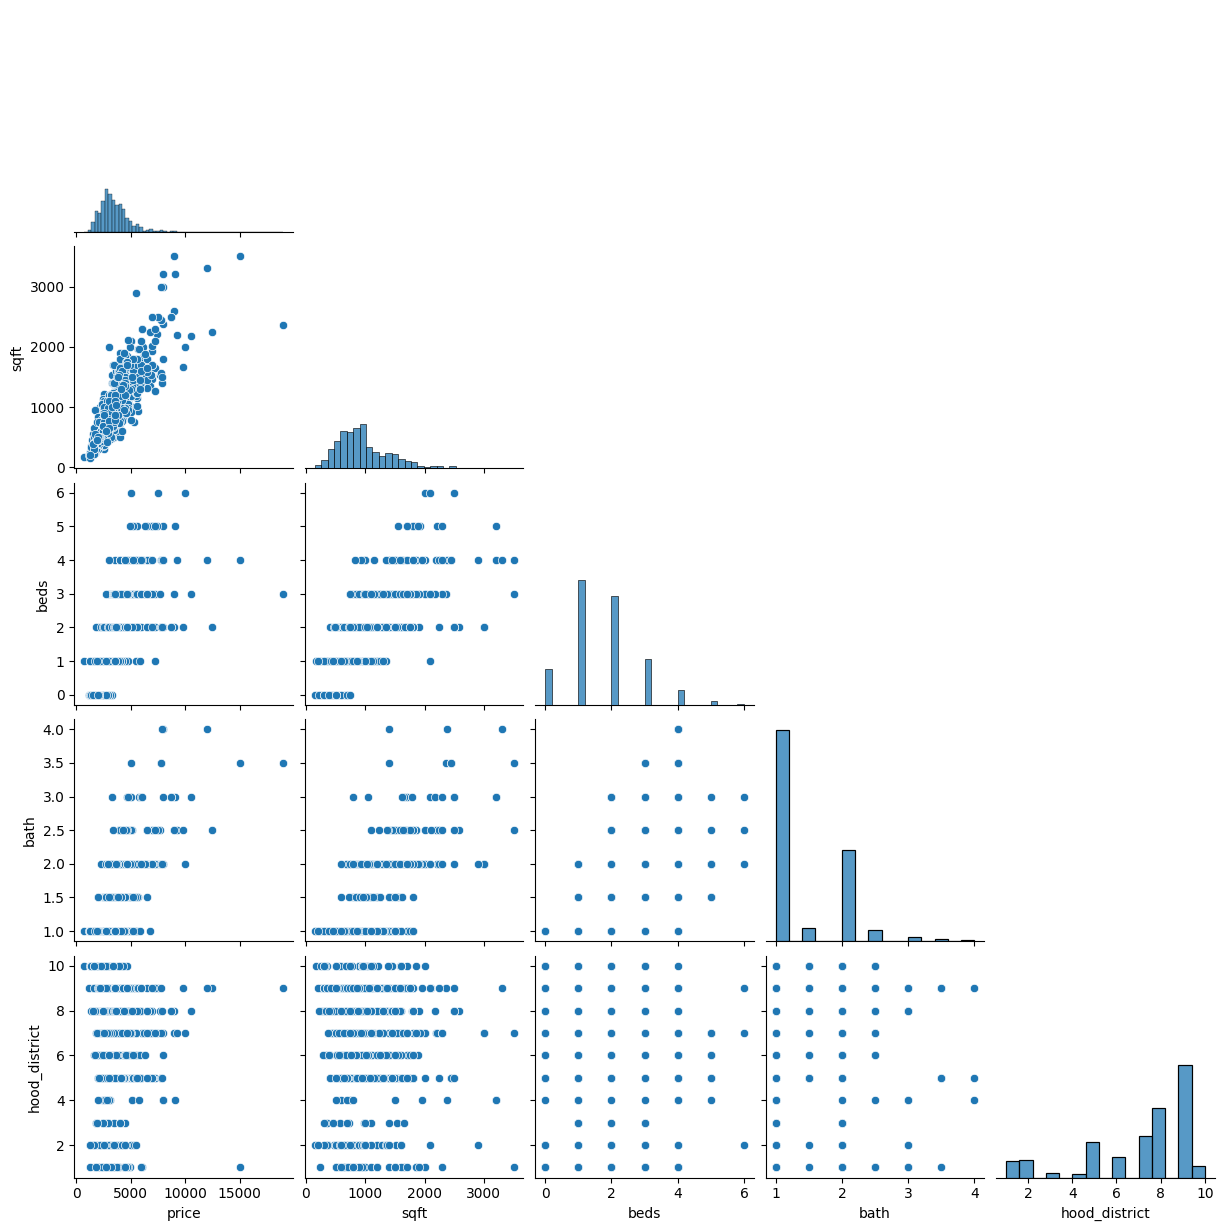

In [10]:
sns.pairplot(rentals_df, 
             corner=True
            )

Moving on to our categorical features, we have some rare categories that may need to be binned together.

We should consider:

1. Pets: Bin 'dogs', and 'both' into a 'dogs' 'allows_dogs' category.
2. Housing_type: Group 'multi' and 'double' together
3. Parking: Group 'protected', 'off-street', and 'valet' together
4. We should bin some of our lower count neighbhoords with neighboring ones. Let's look at average pricing for each and see which are related based on price.

In [13]:
# Let's check the frequency of our categorical features

def value_counter(dataframe):
    value_series = pd.DataFrame()
    for col in dataframe.select_dtypes(["object"]).columns:
        print(dataframe[col].value_counts())
        
        
value_counter(rentals_df)

laundry
(a) in-unit       488
(b) on-site       370
(c) no laundry    131
Name: count, dtype: int64
pets
(d) no pets    510
(a) both       367
(c) cats        91
(b) dogs        21
Name: count, dtype: int64
housing_type
(c) multi     937
(a) single     40
(b) double     12
Name: count, dtype: int64
parking
(d) no parking    478
(b) protected     439
(c) off-street     38
(a) valet          34
Name: count, dtype: int64
hood_district
9.0     332
8.0     207
7.0     123
5.0     106
6.0      62
2.0      51
1.0      50
10.0     33
3.0      14
4.0      11
Name: count, dtype: int64


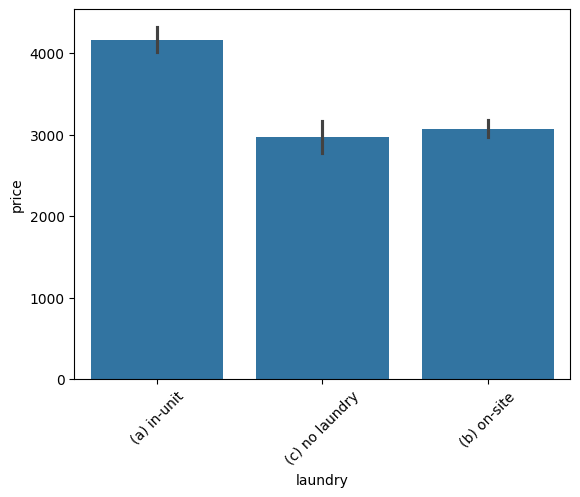

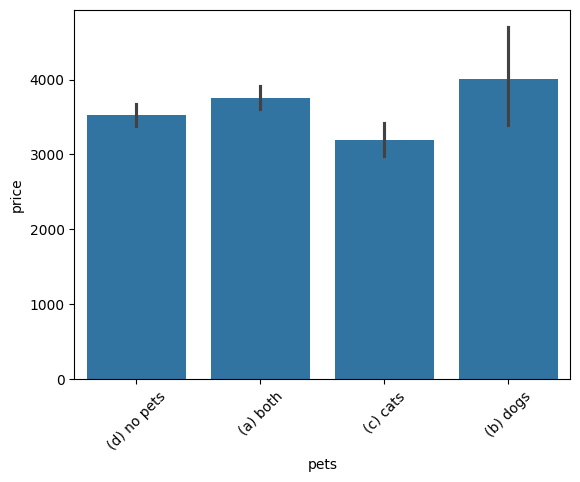

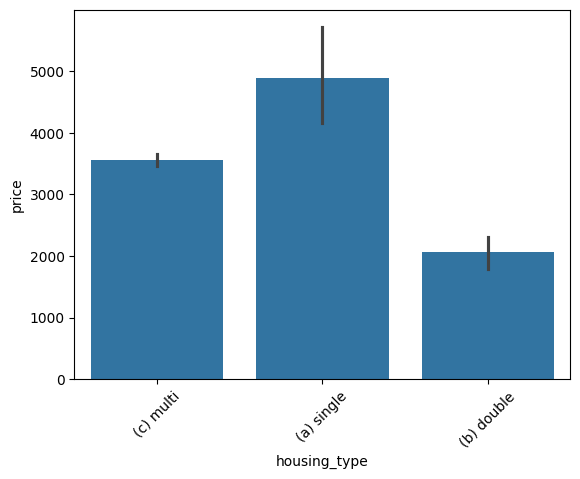

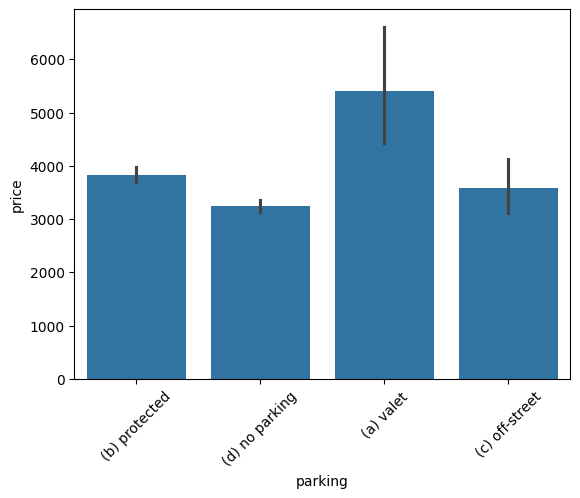

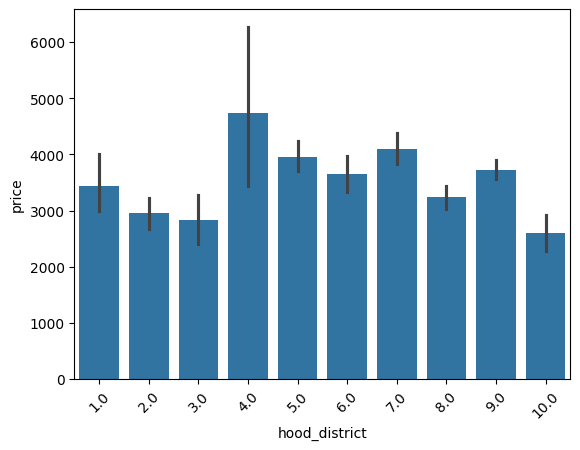

In [14]:
def cat_plotter(data, target):
    for col in data.select_dtypes(["object"]).columns:
        sns.barplot(data=data, x=col, y=target)
        plt.xticks(rotation=45)
        plt.show()
        
cat_plotter(rentals_df, "price")

In [11]:
!git add regression_modelling_project.ipynb
!git commit -m "EDA-4"
!git push origin master

On branch master
Your branch is up to date with 'origin/master'.

Untracked files:
  (use "git add <file>..." to include in what will be committed)
	.ipynb_checkpoints/
	SFAR_map.png
	regression_modelling_project-1.ipynb

nothing added to commit but untracked files present (use "git add" to track)
Everything up-to-date


# Feature Engineering

1. Group Categories together
2. Trying a Squared Term for Bedrooms, sqft, and bath

In [15]:
laundry_map = {
    "(a) in-unit": "in_unit",
    "(b) on-site": "not_in_unit",
    "(c) no laundry": "not_in_unit",
}

pet_map = {
    "(a) both": "allows_dogs",
    "(b) dogs": "allows_dogs",
    "(c) cats": "no_dogs",
    "(d) no pets": "no_dogs"
}


housing_type_map = {
    "(a) single": "single",
    "(b) double": "multi",
    "(c) multi": "multi",
}

district_map = {
    1.0: "west",
    2.0: "southwest",
    3.0: "southwest",
    4.0: "central",
    5.0: "central",
    6.0: "central",
    7.0: "marina",
    8.0: "north beach",
    9.0: "FiDi/SOMA",
    10.0: "southwest"
    
}

In [16]:
eng_df = rentals_df.assign(
    hood_district = rentals_df["hood_district"].map(district_map),
    housing_type = rentals_df["housing_type"].map(housing_type_map),
    pets = rentals_df["pets"].map(pet_map),
    laundry = rentals_df["laundry"].map(laundry_map),
#     sqft2 = rentals_df["sqft"] ** 2,
#     sqft3 = rentals_df["sqft"] ** 3,
#     beds2 = rentals_df["beds"] ** 2,
#     beds3 = rentals_df["beds"] ** 3,
#     bath2 = rentals_df["bath"] ** 2,
#     bath3 = rentals_df["bath"] ** 3,
    beds_bath_ratio = rentals_df["beds"] / rentals_df["bath"]
)

eng_df = pd.get_dummies(eng_df, drop_first=True).astype(int)

In [17]:
eng_df.head()

,price,sqft,beds,bath,beds_bath_ratio,laundry_not_in_unit,pets_no_dogs,housing_type_single,parking_(b) protected,parking_(c) off-street,parking_(d) no parking,hood_district_central,hood_district_marina,hood_district_north beach,hood_district_southwest,hood_district_west
0,6800,1600,2,2,1,0,1,0,1,0,0,0,1,0,0,0
1,3500,550,1,1,1,0,0,0,1,0,0,0,1,0,0,0
2,5100,1300,2,1,2,0,0,0,0,0,1,0,1,0,0,0
3,9000,3500,3,2,1,0,1,0,1,0,0,0,1,0,0,0
4,3100,561,1,1,1,1,0,0,0,0,1,0,1,0,0,0


In [18]:
from sklearn.model_selection import train_test_split

target = "price"
drop_cols = [
    "pets_no_dogs",
    "housing_type_single",
    "beds_bath_ratio"
]

X = sm.add_constant(eng_df.drop([target] + drop_cols, axis=1))

# Log transform slightly improves normality
y = np.log(eng_df[target])
# y = eng_df[target]

# Test Split
X, X_test, y, y_test = train_test_split(X, y, test_size=.2, random_state=2023)

In [19]:
X.dtypes

const                        float64
sqft                           int64
beds                           int64
bath                           int64
laundry_not_in_unit            int64
parking_(b) protected          int64
parking_(c) off-street         int64
parking_(d) no parking         int64
hood_district_central          int64
hood_district_marina           int64
hood_district_north beach      int64
hood_district_southwest        int64
hood_district_west             int64
dtype: object

In [20]:
y.dtypes

dtype('float64')

In [68]:
def cross_val(X, y, n_splits):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=2023)
    # Create a list to store validation scores for each fold

    cv_lm_tr_r2s = []
    cv_lm_tr_mae = []
    cv_lm_val_r2s = []
    cv_lm_val_mae = []
    
    for train_ind, val_ind in kf.split(X, y):
        # Subset data based on CV folds
        X_train, y_train = X.iloc[train_ind], y.iloc[train_ind]
        X_val, y_val = X.iloc[val_ind], y.iloc[val_ind]
        # Fit the Model on fold's training data
        model = sm.OLS(y_train, X_train).fit()
        # Append Validation score to list 
        cv_lm_tr_r2s.append(r2(y_train, model.predict(X_train)))
        cv_lm_tr_mae.append(mae(y_train, model.predict(X_train)))
        cv_lm_val_r2s.append(r2(y_val, model.predict(X_val),))
        cv_lm_val_mae.append(mae(y_val, model.predict(X_val),))
        
        
    print(f"All Training R2s: {[round(x, 3) for x in cv_lm_tr_r2s]}")
    print(f"Training R2s: {round(np.mean(cv_lm_tr_r2s), 3)} +- {round(np.std(cv_lm_tr_r2s), 3)}")
    
    print(f"Training MAEs: {[round(x, 3) for x in cv_lm_tr_mae]}")
    print(f"Training MAEs: {round(np.mean(cv_lm_tr_mae), 3)} +- {round(np.std(cv_lm_tr_mae), 3)}")    
        
    print(f"All Validation R2s: {[round(x, 3) for x in cv_lm_val_r2s]}")
    print(f"Cross Val R2s: {round(np.mean(cv_lm_val_r2s), 3)} +- {round(np.std(cv_lm_val_r2s), 3)}")

    print(f"All Validation MAEs: {[round(x, 3) for x in cv_lm_val_mae]}")
    print(f"Cross Val MAEs: {round(np.mean(cv_lm_val_mae), 3)} +- {round(np.std(cv_lm_val_mae), 3)}")
    
    return model
    
model = cross_val(X, y, 5)

All Training R2s: [0.812, 0.811, 0.801, 0.812, 0.804]
Training R2s: 0.808 +- 0.005
Training MAEs: [0.128, 0.132, 0.132, 0.131, 0.133]
Training MAEs: 0.131 +- 0.002
All Validation R2s: [0.787, 0.785, 0.818, 0.781, 0.81]
Cross Val R2s: 0.796 +- 0.015
All Validation MAEs: [0.146, 0.129, 0.132, 0.136, 0.127]
Cross Val MAEs: 0.134 +- 0.007


In [69]:
# Model p-values: a few features have > .05

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.804
Model:                            OLS   Adj. R-squared:                  0.800
Method:                 Least Squares   F-statistic:                     212.3
Date:                Sat, 08 Nov 2025   Prob (F-statistic):          2.32e-210
Time:                        16:59:41   Log-Likelihood:                 215.27
No. Observations:                 633   AIC:                            -404.5
Df Residuals:                     620   BIC:                            -346.7
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                         7.7936      0.044    176.377      0.000       7.707       7.880
sqft                          0.0004   2.54e-05     15.150      0.000       0.000       0.000
beds                          0.0988      0.010      9.678      0.000       0.079       0.119
bath                          0.0475      0.018      2.640      0.009       0.012       0.083
laundry_not_in_unit          -0.0950      0.016     -5.857      0.000      -0.127      -0.063
parking_(b) protected        -0.2038      0.039     -5.247      0.000      -0.280      -0.128
parking_(c) off-street       -0.1710      0.055     -3.121      0.002      -0.279      -0.063
parking_(d) no parking       -0.2789      0.040     -6.963      0.000      -0.358      -0.200
hood_district_central         0.0269      0.021      1.268      0.205      -0.015       0.069
hood_district_marina          0.0845      0.025      3.443      0.001       0.036       0.133
hood_district_north beach    -0.0186      0.021     -0.902      0.367      -0.059       0.022
hood_district_southwest      -0.1726      0.026     -6.531      0.000      -0.225      -0.121
hood_district_west           -0.0402      0.033     -1.210      0.227      -0.105       0.025
==============================================================================
Omnibus:                       20.883   Durbin-Watson:                   1.939
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               44.296
Skew:                           0.130   Prob(JB):                     2.41e-10
Kurtosis:                       4.270   Cond. No.                     1.30e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.3e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

1. Linearity - no obvious curvature
2. Independence - DW Test Statistic Looks Good!
3. Normality - Slighly off before log transform, much better afterwards... may not be worth interpretability
4. No Perfect MultiCollinearity - VIFs look OK
5. Equal Variance - slight heteroskedasticity prior to log transform

In [70]:
def residual_analysis_plots(model):
    
    import scipy.stats as stats
    import matplotlib.pyplot as plt
    
    predictions = model.predict()
    residuals = model.resid
    
    fig, ax = plt.subplots(1, 2, sharey="all", figsize=(10, 6))
    
    sns.scatterplot(x=predictions, y=residuals, ax=ax[0])
    ax[0].set_title("Residual Plot")
    ax[0].set_xlabel("Prediction")
    ax[0].set_ylabel("Residuals")
    
    stats.probplot(residuals, dist="norm", plot=ax[1])
    ax[1].set_title("Normal Q-Q Plot")   

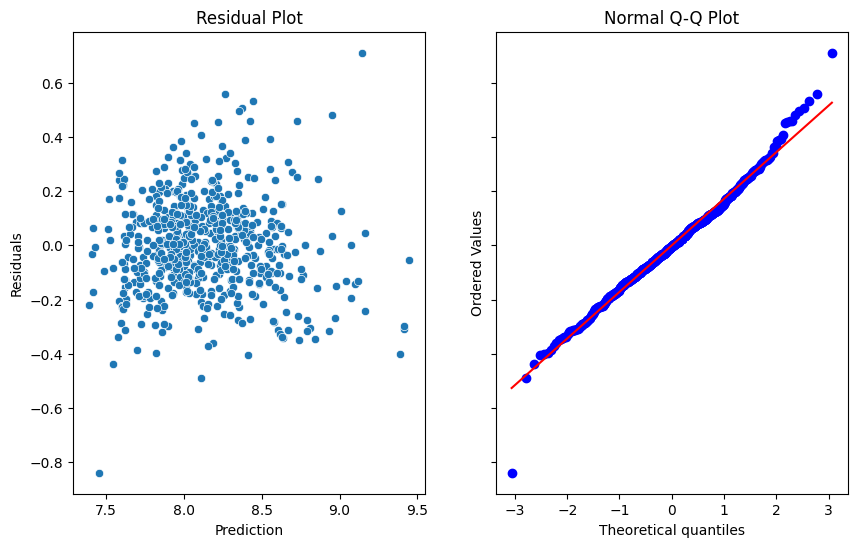

In [71]:
residual_analysis_plots(model)

In [72]:
# VIF Looks OK -- our parking dummy features are a bit high but no major concern

from statsmodels.stats.outliers_influence import variance_inflation_factor as vif

pd.Series(
    [vif(X.values, i) for i in range(X.shape[1])],
    index=X.columns
)

const                        39.845516
sqft                          3.307674
beds                          2.730379
bath                          2.012214
laundry_not_in_unit           1.379659
parking_(b) protected         7.644115
parking_(c) off-street        2.220054
parking_(d) no parking        8.285441
hood_district_central         1.379912
hood_district_marina          1.381014
hood_district_north beach     1.430390
hood_district_southwest       1.314116
hood_district_west            1.209662
dtype: float64

In [73]:
# Outliers
influence = model.get_influence()
inf_summary_df = influence.summary_frame()
inf_summary_df["cooks_d"].sort_values(ascending=False).head()

253    0.082590
56     0.040496
602    0.038916
598    0.028864
863    0.026875
Name: cooks_d, dtype: float64

In [74]:
# Finding the outlier
X.loc[253]

const                           1.0
sqft                         2358.0
beds                            3.0
bath                            3.0
laundry_not_in_unit             0.0
parking_(b) protected           0.0
parking_(c) off-street          0.0
parking_(d) no parking          0.0
hood_district_central           0.0
hood_district_marina            0.0
hood_district_north beach       0.0
hood_district_southwest         0.0
hood_district_west              0.0
Name: 253, dtype: float64

In [75]:
# Because I used log.
np.exp(X.loc[253])

/home/tahar/.pyenv/versions/3.12.9/envs/proftg/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


const                         2.718282
sqft                               inf
beds                         20.085537
bath                         20.085537
laundry_not_in_unit           1.000000
parking_(b) protected         1.000000
parking_(c) off-street        1.000000
parking_(d) no parking        1.000000
hood_district_central         1.000000
hood_district_marina          1.000000
hood_district_north beach     1.000000
hood_district_southwest       1.000000
hood_district_west            1.000000
Name: 253, dtype: float64

In [76]:
!git add regression_modelling_project.ipynb
!git commit -m "Feature Engineering"
!git push origin master

On branch master
Your branch is up to date with 'origin/master'.

Untracked files:
  (use "git add <file>..." to include in what will be committed)
	.ipynb_checkpoints/
	SFAR_map.png
	regression_modelling_project-1.ipynb

nothing added to commit but untracked files present (use "git add" to track)
Everything up-to-date


## Final Model Fit

In [77]:
final_model = sm.OLS(y, X).fit()

final_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.807
Model:                            OLS   Adj. R-squared:                  0.804
Method:                 Least Squares   F-statistic:                     271.7
Date:                Sat, 08 Nov 2025   Prob (F-statistic):          1.67e-268
Time:                        16:59:58   Log-Likelihood:                 282.88
No. Observations:                 791   AIC:                            -539.8
Df Residuals:                     778   BIC:                            -479.0
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                         7.7637      0.038    202.731      0.000       7.689       7.839
sqft                          0.0004   2.32e-05     17.035      0.000       0.000       0.000
beds                          0.0997      0.009     10.867      0.000       0.082       0.118
bath                          0.0480      0.016      2.984      0.003       0.016       0.080
laundry_not_in_unit          -0.0939      0.014     -6.591      0.000      -0.122      -0.066
parking_(b) protected        -0.1821      0.034     -5.382      0.000      -0.249      -0.116
parking_(c) off-street       -0.1892      0.046     -4.124      0.000      -0.279      -0.099
parking_(d) no parking       -0.2576      0.035     -7.373      0.000      -0.326      -0.189
hood_district_central         0.0302      0.019      1.606      0.109      -0.007       0.067
hood_district_marina          0.0856      0.021      3.989      0.000       0.043       0.128
hood_district_north beach    -0.0215      0.018     -1.192      0.234      -0.057       0.014
hood_district_southwest      -0.1967      0.023     -8.530      0.000      -0.242      -0.151
hood_district_west           -0.0529      0.030     -1.778      0.076      -0.111       0.006
==============================================================================
Omnibus:                       19.512   Durbin-Watson:                   1.880
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               35.459
Skew:                           0.138   Prob(JB):                     2.00e-08
Kurtosis:                       4.000   Cond. No.                     1.25e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.25e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [81]:
print(mae(np.exp(y_test), np.exp(final_model.predict(X_test)))) 
# print(f"Test MAE: {mae(y_test, model.predict(X_test))}") #468.13 if not transformed
print(f"Test R2: {r2(y_test, final_model.predict(X_test))}")

441.38654807375036
Test R2: 0.7856574119548013


In [82]:
!git add regression_modelling_project.ipynb
!git commit -m "Final Model Fit"
!git push origin master

[master c4eba70] Final Model Fit
 1 file changed, 141 insertions(+), 126 deletions(-)
Enumerating objects: 5, done.
Counting objects: 100% (5/5), done.
Delta compression using up to 22 threads
Compressing objects: 100% (3/3), done.
Writing objects: 100% (3/3), 1.50 KiB | 308.00 KiB/s, done.
Total 3 (delta 2), reused 0 (delta 0), pack-reused 0
remote: Resolving deltas: 100% (2/2), completed with 2 local objects.
To github.com:Proftg/SAN-FRANCISCO-RENT-PRICES.git
   71e8248..c4eba70  master -> master
